In [ ]:
# Install necessary libraries
!pip install pycaret
!pip install pycaret[full]
!pip install nfl_data_py



In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from nfl_data_py import import_pbp_data
from pycaret.classification import *


In [3]:
# Load and combine historical training data
df_train = import_pbp_data([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])
df_train = df_train[df_train['down'] == 4].copy()

# Create target label based on play type
df_train['decision'] = df_train['play_type'].map({
    'pass': 'go for it',
    'run': 'go for it',
    'punt': 'punt',
    'field_goal': 'field goal'
})

# Drop missing decisions
df_train = df_train[df_train['decision'].notna()]

# Define features
selected_features = [
    'yardline_100',
    'ydstogo',
    'score_differential',
    'game_seconds_remaining',
    'qtr',
    'posteam_timeouts_remaining',
    'defteam_timeouts_remaining'
]

# Clean training data
train_data = df_train[selected_features + ['decision']].dropna()


2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [4]:
# Train PyCaret model
clf = setup(data=train_data, target='decision', session_id=42, verbose=False)
best_model = compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9148,0.9833,0.9148,0.9123,0.9128,0.8485,0.8492,2.2410
catboost,CatBoost Classifier,0.9142,0.9833,0.9142,0.9115,0.9121,0.8473,0.8479,12.9920
xgboost,Extreme Gradient Boosting,0.9117,0.9824,0.9117,0.9090,0.9097,0.8430,0.8436,0.6940
gbc,Gradient Boosting Classifier,0.9113,0.0000,0.9113,0.9084,0.9091,0.8420,0.8427,4.9240
rf,Random Forest Classifier,0.9060,0.9781,0.9060,0.9030,0.9038,0.8328,0.8335,2.1430
et,Extra Trees Classifier,0.8938,0.9746,0.8938,0.8893,0.8903,0.8103,0.8114,1.6830
dt,Decision Tree Classifier,0.8719,0.8997,0.8719,0.8726,0.8722,0.7751,0.7752,0.2570
knn,K Neighbors Classifier,0.8571,0.9447,0.8571,0.8482,0.8471,0.7435,0.7473,0.2830
qda,Quadratic Discriminant Analysis,0.8560,0.0000,0.8560,0.8460,0.8482,0.7420,0.7442,0.0890
lda,Linear Discriminant Analysis,0.8487,0.0000,0.8487,0.8354,0.8351,0.7266,0.7317,0.1080


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [5]:
#save best model

from pycaret.classification import save_model

save_model(best_model, '4th_down_model')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['yardline_100', 'ydstogo',
                                              'score_differential',
                                              'game_seconds_remaining', 'qtr',
                                              'posteam_timeouts_remaining',
                                              'defteam_timeouts_remaining'],
                                     tran...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                                 min_child

In [6]:
# Load 2024 data and prep for testing
df_test = import_pbp_data([2024])
df_test = df_test[df_test['down'] == 4].copy()

df_test['actual_decision'] = df_test['play_type'].map({
    'pass': 'go for it',
    'run': 'go for it',
    'punt': 'punt',
    'field_goal': 'field goal'
})

df_test = df_test[df_test['actual_decision'].notna()]
df_test = df_test.dropna(subset=selected_features)


2024 done.
Downcasting floats.


In [7]:
# Run model predictions on 2024 plays
test_data = df_test[selected_features]
predictions = predict_model(best_model, data=test_data)

In [8]:
# Combine predictions with actual results
df_test['model_decision'] = predictions['prediction_label']
df_test['confidence'] = predictions['prediction_score']

comparison_df = df_test[[
    'game_id', 'play_id', 'yardline_100', 'ydstogo', 'score_differential',
    'game_seconds_remaining', 'qtr', 'actual_decision', 'model_decision',
    'confidence', 'epa', 'success', 'posteam', 'defteam'
]].copy()


In [9]:
# Evaluate model vs. actual
comparison_df['agreement'] = comparison_df['actual_decision'] == comparison_df['model_decision']

# Count disagreements
disagreements = comparison_df[~comparison_df['agreement']]
print(f"Number of disagreements: {len(disagreements)}")


Number of disagreements: 416


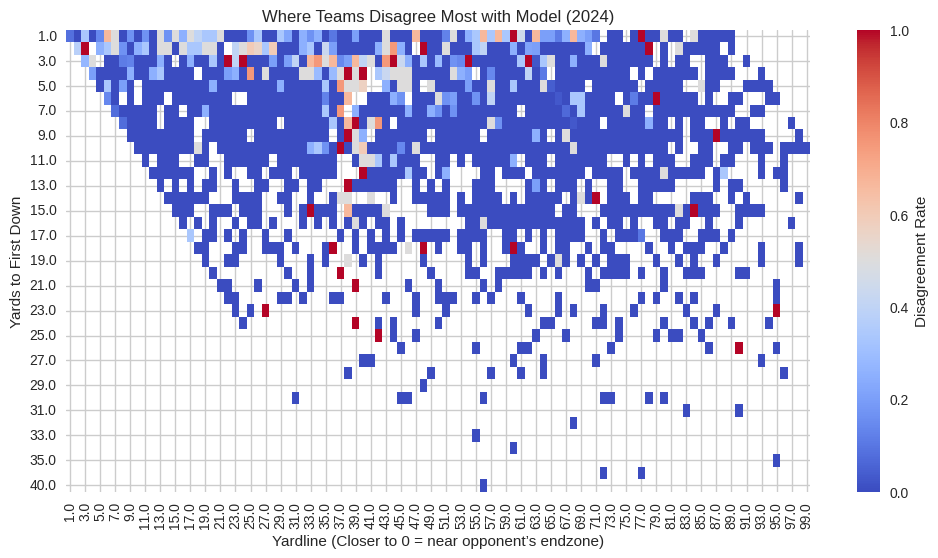

In [10]:
# create a visualization to show where teams disagree with the model
import seaborn as sns

heat_data = comparison_df.copy()
heat_data['disagree'] = heat_data['actual_decision'] != heat_data['model_decision']
pivot = heat_data.pivot_table(index='ydstogo', columns='yardline_100', values='disagree', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='coolwarm', cbar_kws={'label': 'Disagreement Rate'})
plt.title('Where Teams Disagree Most with Model (2024)')
plt.xlabel('Yardline (Closer to 0 = near opponent’s endzone)')
plt.ylabel('Yards to First Down')
plt.show()


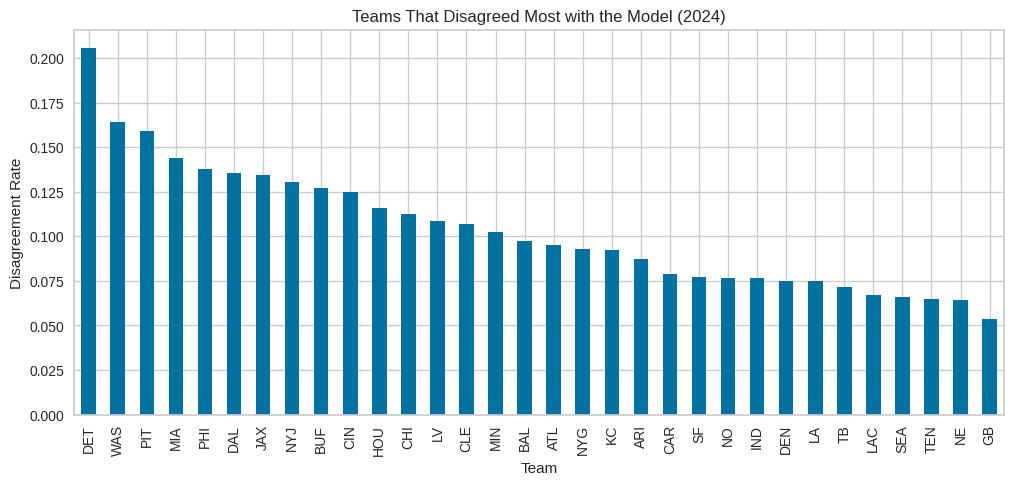

In [11]:
# creating visualization to show the teams that disagree with the model the most

team_disagreement = comparison_df.groupby('posteam')['agreement'].mean().reset_index()
team_disagreement['disagree_rate'] = 1 - team_disagreement['agreement']

team_disagreement.sort_values('disagree_rate', ascending=False).plot(
    x='posteam', y='disagree_rate', kind='bar', figsize=(12,5), legend=False
)
plt.title('Teams That Disagreed Most with the Model (2024)')
plt.ylabel('Disagreement Rate')
plt.xlabel('Team')
plt.show()


In [12]:
comparison_df['go_for_it_model'] = (comparison_df['model_decision'] == 'go for it').astype(int)
comparison_df['punt_model'] = (comparison_df['model_decision'] == 'punt').astype(int)
comparison_df['fg_model'] = (comparison_df['model_decision'] == 'field goal').astype(int)



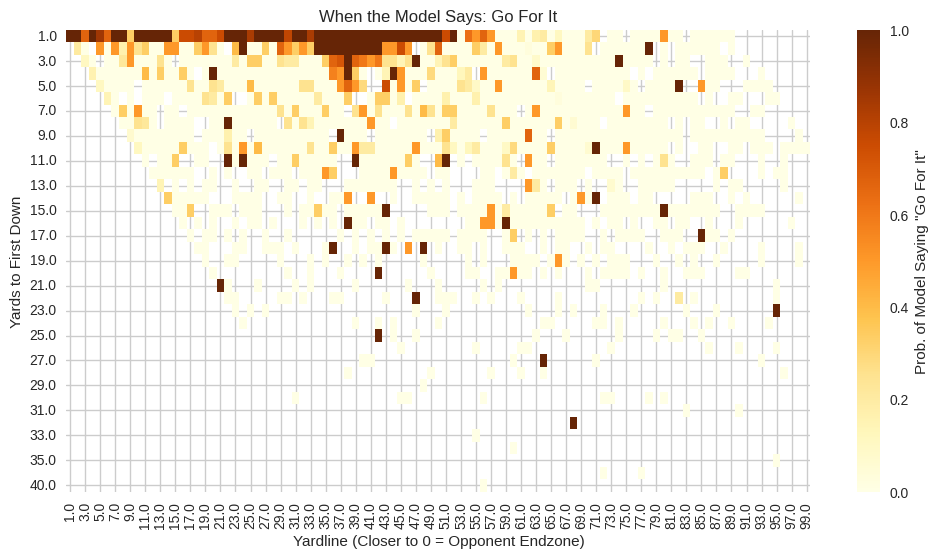

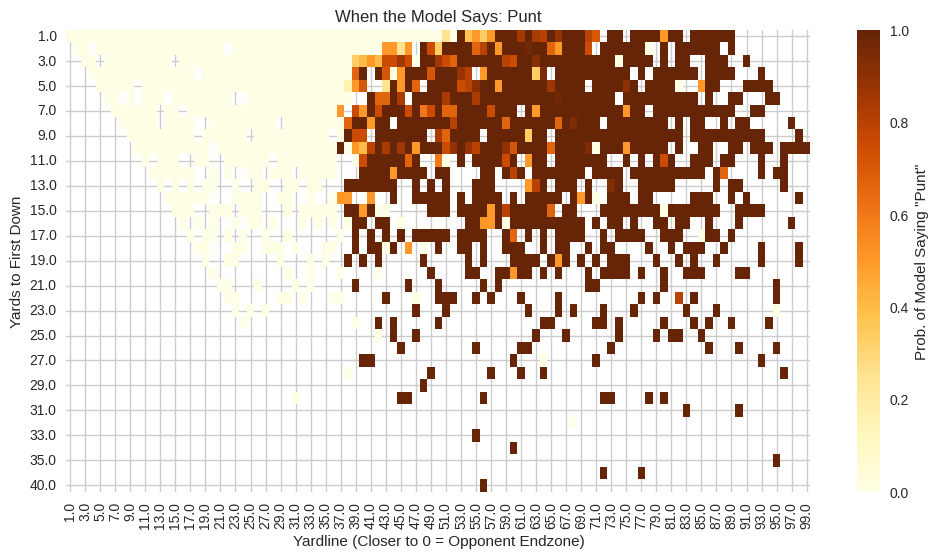

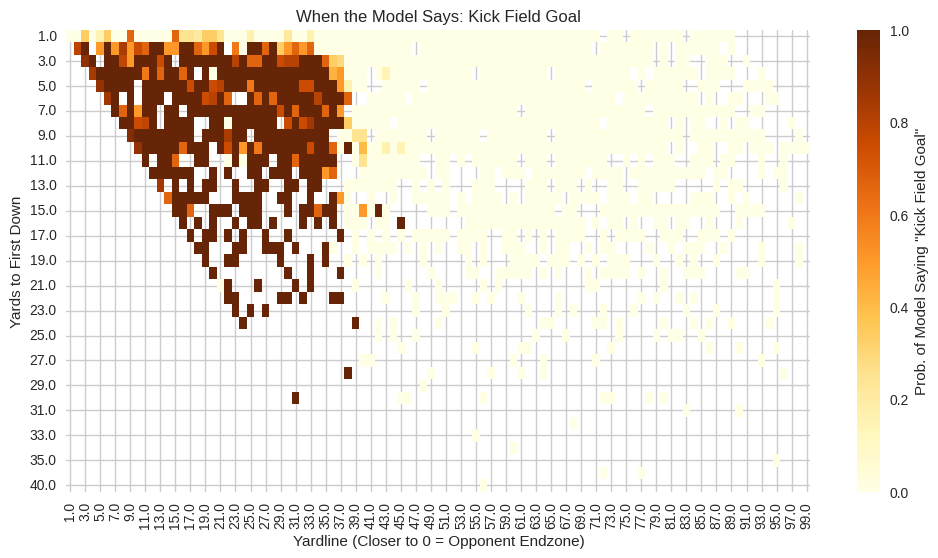

In [13]:
# creating visualizations of when the model says to go for it, kick it, or punt it
import seaborn as sns
import matplotlib.pyplot as plt

def plot_decision_zone(decision_col, title):
    heatmap_data = comparison_df.pivot_table(
        index='ydstogo',
        columns='yardline_100',
        values=decision_col,
        aggfunc='mean'
    )

    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap='YlOrBr', cbar_kws={'label': f'Prob. of Model Saying "{title}"'})
    plt.title(f'When the Model Says: {title}')
    plt.xlabel('Yardline (Closer to 0 = Opponent Endzone)')
    plt.ylabel('Yards to First Down')
    plt.show()

# Run for each type of decision
plot_decision_zone('go_for_it_model', 'Go For It')
plot_decision_zone('punt_model', 'Punt')
plot_decision_zone('fg_model', 'Kick Field Goal')


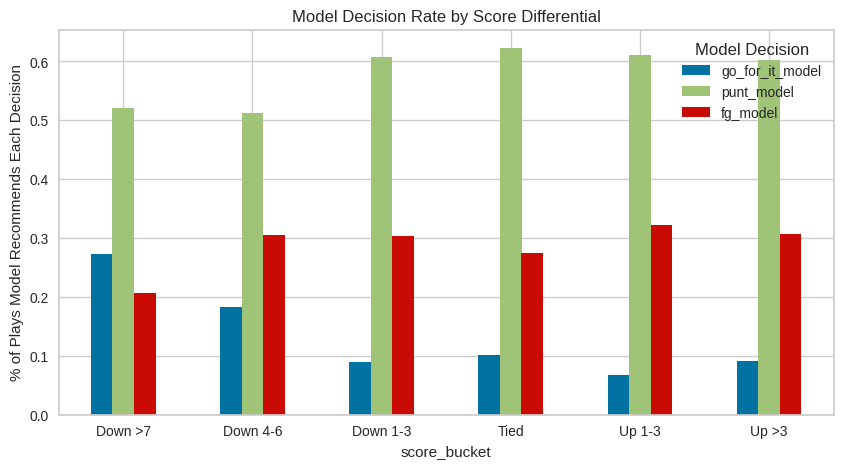

In [14]:
comparison_df['score_bucket'] = pd.cut(
    comparison_df['score_differential'],
    bins=[-100, -7, -3, 0, 3, 7, 100],
    labels=['Down >7', 'Down 4-6', 'Down 1-3', 'Tied', 'Up 1-3', 'Up >3']
)

decision_rates = comparison_df.groupby('score_bucket')[
    ['go_for_it_model', 'punt_model', 'fg_model']
].mean()

decision_rates.plot(kind='bar', figsize=(10, 5))
plt.title('Model Decision Rate by Score Differential')
plt.ylabel('% of Plays Model Recommends Each Decision')
plt.xticks(rotation=0)
plt.legend(title='Model Decision')
plt.show()


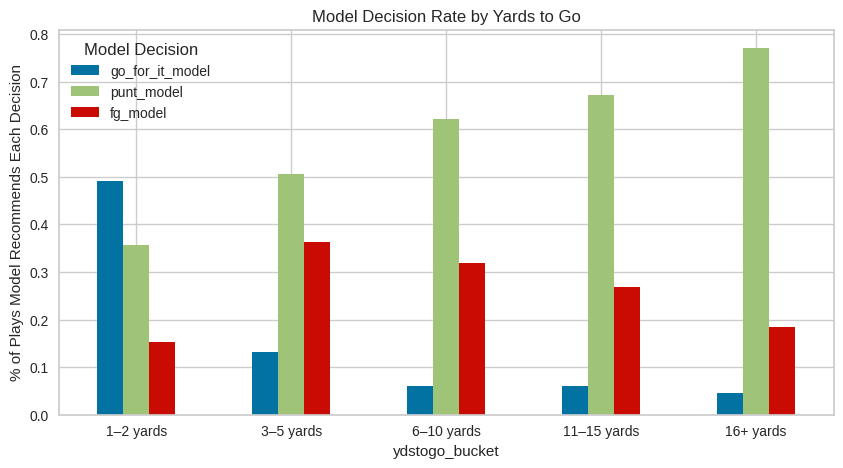

In [15]:
# Create yard-to-go buckets
comparison_df['ydstogo_bucket'] = pd.cut(
    comparison_df['ydstogo'],
    bins=[0, 2, 5, 10, 15, 100],
    labels=['1–2 yards', '3–5 yards', '6–10 yards', '11–15 yards', '16+ yards']
)

# Group and calculate model decision rates
ydstogo_rates = comparison_df.groupby('ydstogo_bucket')[
    ['go_for_it_model', 'punt_model', 'fg_model']
].mean()

# Plot
ydstogo_rates.plot(kind='bar', figsize=(10, 5))
plt.title('Model Decision Rate by Yards to Go')
plt.ylabel('% of Plays Model Recommends Each Decision')
plt.xticks(rotation=0)
plt.legend(title='Model Decision')
plt.show()



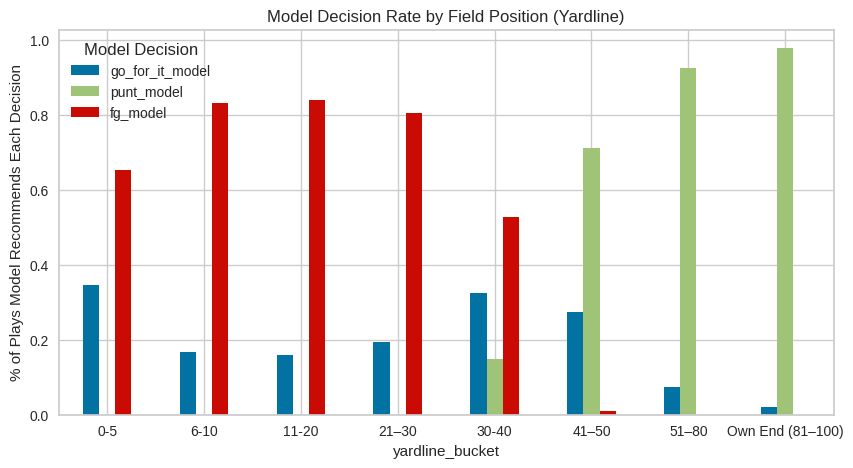

In [16]:
# Create yardline buckets (closer to 0 = near opponent's goal line)
comparison_df['yardline_bucket'] = pd.cut(
    comparison_df['yardline_100'],
    bins=[0, 5, 10, 20, 30, 40, 50, 80, 100],
    labels=['0-5', '6-10', '11-20', '21–30', '30-40', '41–50', '51–80', 'Own End (81–100)']
)

# Group and calculate model decision rates
yardline_rates = comparison_df.groupby('yardline_bucket')[
    ['go_for_it_model', 'punt_model', 'fg_model']
].mean()

# Plot
yardline_rates.plot(kind='bar', figsize=(10, 5))
plt.title('Model Decision Rate by Field Position (Yardline)')
plt.ylabel('% of Plays Model Recommends Each Decision')
plt.xticks(rotation=0)
plt.legend(title='Model Decision')
plt.show()


In [17]:
def predict_4th_down_decision(
    yardline_100,
    ydstogo,
    score_differential,
    game_seconds_remaining,
    qtr,
    posteam_timeouts_remaining,
    defteam_timeouts_remaining
):
    input_df = pd.DataFrame([{
        'yardline_100': yardline_100,
        'ydstogo': ydstogo,
        'score_differential': score_differential,
        'game_seconds_remaining': game_seconds_remaining,
        'qtr': qtr,
        'posteam_timeouts_remaining': posteam_timeouts_remaining,
        'defteam_timeouts_remaining': defteam_timeouts_remaining
    }])

    result = predict_model(best_model, data=input_df)
    decision = result['prediction_label'][0]
    confidence = result['prediction_score'][0]
    print(f"\nModel Decision: {decision.upper()} (Confidence: {confidence:.2%})")


In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to make the prediction
def predict_4th_down_decision(
    yardline_100,
    ydstogo,
    score_differential,
    game_seconds_remaining,
    qtr,
    posteam_timeouts_remaining,
    defteam_timeouts_remaining
):
    input_df = pd.DataFrame([{
        'yardline_100': yardline_100,
        'ydstogo': ydstogo,
        'score_differential': score_differential,
        'game_seconds_remaining': game_seconds_remaining,
        'qtr': qtr,
        'posteam_timeouts_remaining': posteam_timeouts_remaining,
        'defteam_timeouts_remaining': defteam_timeouts_remaining
    }])

    result = predict_model(best_model, data=input_df)
    decision = result['prediction_label'][0]
    confidence = result['prediction_score'][0]
    print(f"\nModel Decision: {decision.upper()}")
    print(f"Confidence: {confidence:.2%}")

# Create sliders
yardline = widgets.IntSlider(value=50, min=1, max=99, description='Yardline:')
ydstogo = widgets.IntSlider(value=5, min=1, max=20, description='Yards to Go:')
score_diff = widgets.IntSlider(value=0, min=-30, max=30, description='Score Diff:')
seconds = widgets.IntSlider(value=900, min=0, max=3600, step=30, description='Time Left:')
quarter = widgets.IntSlider(value=2, min=1, max=4, description='Quarter:')
team_timeouts = widgets.IntSlider(value=3, min=0, max=3, description='Own TOs:')
def_timeouts = widgets.IntSlider(value=3, min=0, max=3, description='Def TOs:')

# Output area
output = widgets.Output()

# Submit button
submit_btn = widgets.Button(description="Submit", button_style='success')

# What happens when you click "Submit"
def on_submit(b):
    with output:
        clear_output()  # Clear previous prediction
        predict_4th_down_decision(
            yardline_100=yardline.value,
            ydstogo=ydstogo.value,
            score_differential=score_diff.value,
            game_seconds_remaining=seconds.value,
            qtr=quarter.value,
            posteam_timeouts_remaining=team_timeouts.value,
            defteam_timeouts_remaining=def_timeouts.value
        )

submit_btn.on_click(on_submit)

# Layout
ui = widgets.VBox([
    yardline, ydstogo, score_diff, seconds,
    quarter, team_timeouts, def_timeouts, submit_btn, output
])

display(ui)
